# Sports Schedule Pipeline
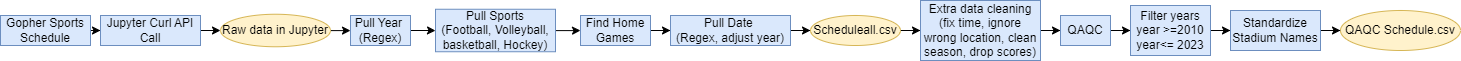

###### Credits:ChatGPT and Draw.io

## Import Statements

In [33]:
import csv
import time
from datetime import datetime
import subprocess
import pandas as pd
import re
import os

## File Path

In [34]:
#location to current directory
file_path = os.path.dirname(arcpy.mp.ArcGISProject('CURRENT').filePath)
os.chdir(file_path)
#absolute Path for geodatabase
file_path_db = file_path + '\\Sports_Data'
arcpy.env.workspace = file_path_db

## Data Preperation

In [35]:
#the update_year function takes year_string and month_string as input.
#adjusts the year and if its a split year season and returns the updated year.
def update_year(year_string, month_string):
    #if the year_string contains dash, indicating a split year season
    if '-' in year_string:
        #split the year range into two parts
        year_range_list = year_string.split('-')
        #convert both parths of the year range into integers
        first, second = map(int, year_range_list)
        
        #adjust years depending on the year they fall
        #example: 2015-16 it takes the 2015 and since this 2015 >= 2000 then its (16+2000)= 2016 
        if first == 1899:
            #if the first part of the year is 1899, set the year_string to '1900'
            year_string = '1900'
        elif first == 1999:
            #if the first part of the year is 1999, set the year_string to '2000'
            year_string = '2000'
        elif 1800 <= first < 2000:
            #if the first part of the year is between 1800 and 1999, adjust the year_string by adding the second part of the year and the nearest century
            year_string = str(second + (first // 100) * 100)
        elif first >= 2000:
            #if the first part of the year is 2000 or later, adjust the year_string by adding the second part of the year to 2000
            year_string = str(second + 2000)
        
        #use the first year if the month is June- December
        if int(month_string) > 5:
            year_string = str(first)
    #return the updated year_string
    #year column is created
    return year_string

## Downloading Sports Data

In [36]:
#iterates through the list and pulls all the rows of sports data to be saved to a csv
def process_gamecode(gamecode, all_data_rows):
    #construct the URL for retreiving schedule data
    url = f"https://gophersports.com/services/schedule_txt.ashx?schedule={gamecode}"
    #print the current iteration (game) the code is going through
    print(gamecode)
    while True:
        #use curl command to retreive the data from the URL
        curl_process = subprocess.Popen(['curl', '-s', url], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        #capture errors (schedule not found)
        response, error = curl_process.communicate()
        #check if the curl process executed sucessfully
        if curl_process.returncode == 0:
            #splits response into lines
            lines = response.decode('utf-8').split("\n")
            try:
                #extract the second row from the response-- removes white space
                second_row = lines[1].strip()
            except IndexError:
                print(f"Index Error for {gamecode}. No Schedule")
                break
            #finds year from second row
            year_str_match = re.match(r'(\d{4}-\d{2}|\d{4})', second_row)
            year_str = year_str_match.group(1) if year_str_match else None
            #extract the season/sport from the second row
            season = second_row.replace("Schedule", "").strip()
            #check if the season corresponds to certain sports
            if any(sport in season for sport in ["Football", "Volleyball", "Men's Basketball", "Men's Hockey", "Men's Ice Hockey"]):
                #process each line of the response (actual events)
                for line in lines[10:]:
                    #split the row into new elements
                    data = re.split(r'\s{2,}', line.strip())
                    #check if the data contains valid information and is not away or Neutral
                    if len(data) > 2 and data[2] not in ["Away", "Neutral"]:
                        #exclude header and adjust date format
                        if data[0] != "Date" or data[1] != "Time":
                            date_without_day = re.sub(r'\s*\([^)]*\)', '', data[0])
                            month_str = datetime.strptime(date_without_day + " 2000", "%b %d %Y").strftime("%m")
                            year_str_for_row = update_year(year_str, month_str)
                            combined_date = datetime.strptime(f"{date_without_day} {year_str_for_row}", "%b %d %Y").strftime("%m/%d/%Y")
                            #combine the date and year
                            data[0] = combined_date
                            #append the adjusted data to the all_data_rows list
                            all_data_rows.append([year_str_for_row, season] + data)
            break
        else:
            #print any error that happens through the process
            print(f"Error: {error.decode('utf-8')} at {url}")
        time.sleep(0)

#initialize an empty list to store all the data rows
all_data_rows = []
#define a list of gamecodes (sport_list) to process
sport_list = list(range(1, 800))

#loop through each gamecode and process
for gamecode in sport_list:
    process_gamecode(gamecode, all_data_rows)

1
2
3
Index Error for 3. No Schedule
4
Index Error for 4. No Schedule
5
Index Error for 5. No Schedule
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
Error:  at https://gophersports.com/services/schedule_txt.ashx?schedule=44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
Error:  at https://gophersports.com/services/schedule_txt.ashx?schedule=69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
2

## Saves to CSV

In [37]:
#define the output file name
output_file_name = "all_games_schedule.csv"
#open the file and write all games to CSV
with open(output_file_name, "w", newline='', encoding='utf-8') as csv_file:
    csv_writer = csv.writer(csv_file)
    #write the header row
    csv_writer.writerow(["Year", "Season", "Date", "Time", "At", "Opponent", "Location", "Score"])
    #write all data rows
    for game_row in all_data_rows:
        csv_writer.writerow(game_row)
#confirm the data has been written
print(f"Data has been written to the file: '{output_file_name}'")

Data has been written to the file: 'all_games_schedule.csv'


## QAQC and Data Cleaning on CSV

In [40]:
#define the path to the input CSV file
input_csv_path = "all_games_schedule.csv"
#read the CSV file into a dataframe
df = pd.read_csv(input_csv_path)
#filter out rows where the stadium is labeled TBD
df_filtered = df[~df['Location'].str.contains('TBD')].copy()
#filter out rows where 'time' contains 'TBA' or 'TBD'
df_filtered = df_filtered[~df_filtered['Time'].str.contains(r'^[^0-9]*$', regex=True)].copy()
#remove rows with state names in the location
df_filtered = df_filtered[~df_filtered['Location'].str.contains('Calif.|Ind.|Colo.')]
#QAQC (Logical Consistency/range check): filter to years with traffic history (for road dataset for final project)
df_filtered = df_filtered[(df_filtered['Year'] <= 2023) & (df_filtered['Year'] >= 2010)]
#QAQC:(Thematic Accuracy): ensure consistent stadium names
df_filtered.loc[df_filtered['Location'] == 'TCF Bank Stadium', 'Location'] = 'Huntington Bank Stadium'
df_filtered.loc[df_filtered['Location'] == 'Mariucci Arena', 'Location'] = '3M Arena at Mariucci'
df_filtered.loc[df_filtered['Location'] == 'Sports Pavilion', 'Location'] = 'Maturi Pavilion'
#replace "TBD (Stadium)" with the stadium name
df_filtered['Location'] = df_filtered['Location'].str.replace(r'\bTBD \((.+?)\)', r'\1', regex=True)
df_filtered['Location'] = df_filtered['Location'].str.replace(r'.*\((.*)\).*', r'\1', regex=True)
#remove years from the season column
df_filtered['Season'] = df_filtered['Season'].str.replace(r'\d+|-', '', regex=True)
#drop the last column
df_filtered.drop('Score', axis=1, inplace=True)
#remove 'Men's' or 'Women's' label
df_filtered['Season'] = df_filtered['Season'].str.replace(r"Men's|Women's|Ice", '', regex=True)
#define the path for the output CSV file
output_csv_path = "filtered_schedule.csv"
#write the filtered DataFrame to a new CSV file
df_filtered.to_csv(output_csv_path, index=False)
print(f"Filtered data has been saved to '{output_csv_path}'")

Filtered data has been saved to 'filtered_schedule.csv'
